In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import warnings
warnings.filterwarnings("ignore")
start_time = time.time()

In [2]:
n_customer = 18
n_point = n_customer+1
vehicle_capacity = 400

df = pd.DataFrame({
    'x': (23.7791509939155,23.7057442244029,23.7926366806198,23.8858286334404,23.8391319043898,23.8583653902307,23.9371371924135,23.9240822361424,23.9490218369133,23.9195025945173,23.6248125897135,23.7857192154473,23.9898643687822,23.8091231914690,23.9999856622965,24.0266332915962,23.6370879489591,23.4664026717638,23.8610461690743),
    'y': (90.3598076895889,90.3914945343488,90.2679466662192,90.4015409619703,90.2566349338854,90.2619487472768,90.2896183198397,90.2611600411098,90.2745243769025,90.2111853698880,90.4989277706365,90.5689488781001,90.3801430690000,90.1480571832337,90.2740031235854,90.4228718359339,90.5980341876852,90.2872062835397,90.0009284340897),
    'demand':(0,53,51,40,50,48,42,46,50,40,46,48,53,55,43,53,51,57,55),
})

df.iloc[0]['x'] = 23.7791487530086
df.iloc[0]['y'] = 90.3798071183091
df.iloc[0]['demand'] = 0

df

,x,y,demand
0,23.779151,90.359808,0
1,23.705744,90.391495,53
2,23.792637,90.267947,51
3,23.885829,90.401541,40
4,23.839132,90.256635,50
5,23.858365,90.261949,48
6,23.937137,90.289618,42
7,23.924082,90.261160,46
8,23.949022,90.274524,50
9,23.919503,90.211185,40


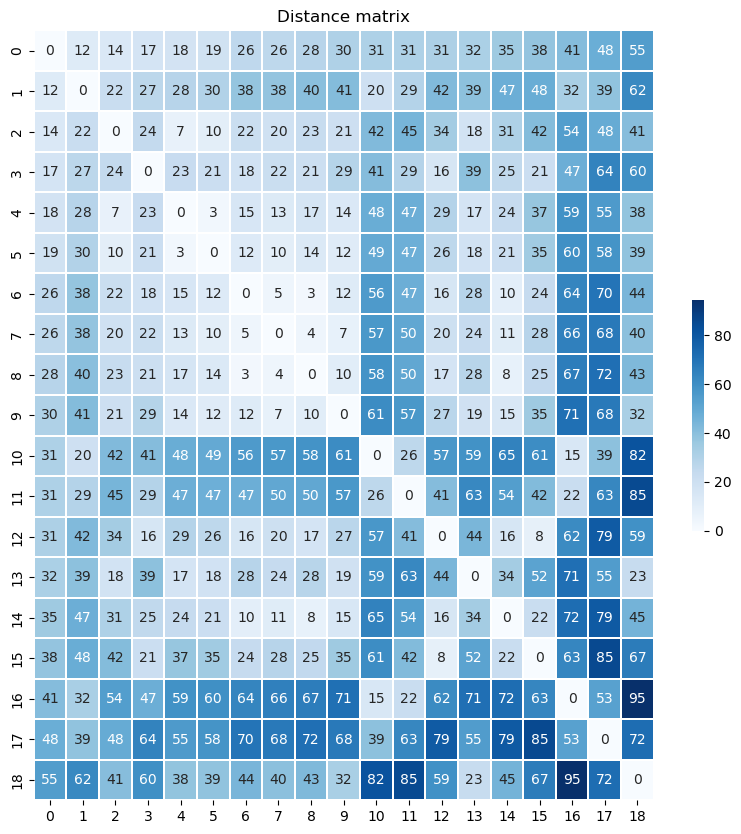

In [3]:
distances = pd.DataFrame(distance_matrix(df[['x', 'y']*22000].values, df[['x', 'y']*22000].values), index=df.index, columns=df.index).values
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('Distance matrix')
plt.show()

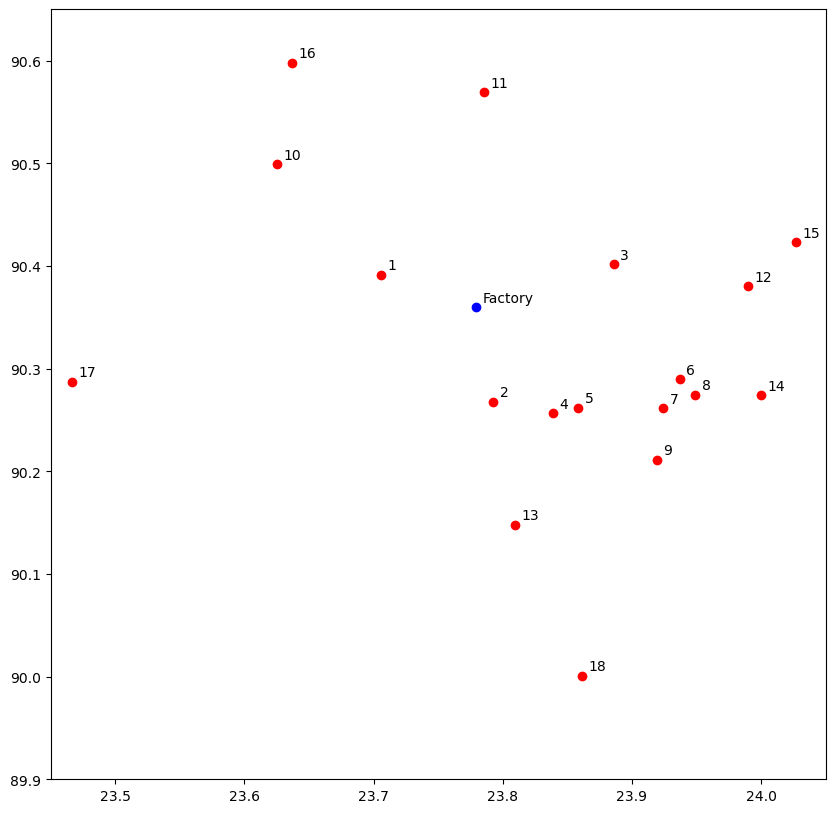

In [4]:
plt.figure(figsize=(10, 10))
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='b')
        plt.text(row['x'] + 0.005, row['y'] + 0.005, 'Factory')
    else:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 0.005, row['y'] + 0.005, f'{i}')
plt.xlim([23.45, 24.05])
plt.ylim([89.9, 90.65])
plt.show()

In [5]:
demands = df['demand'].values

In [6]:
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

In [7]:
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=3, upBound=4, cat='Integer')

In [8]:
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

In [9]:
for i in range(n_point):
    problem += x[i, i] == 0
    
for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
        
problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle
problem += pulp.lpSum(x[0, i] for i in range(n_point)) == n_vehicle

In [10]:
subtours = []
for length in range(2, n_point):
     subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

In [11]:
status = problem.solve()

In [12]:
end_time = time.time()
cpu_time = end_time - start_time

In [13]:
print("Status value:", status)
print("Status:", pulp.LpStatus[status])
print("Objective value:", pulp.value(problem.objective))
print("Number of vehicles used:", pulp.value(n_vehicle))
print("CPU time:", cpu_time, "seconds")

Status value: 1
Status: Optimal
Objective value: 381.14041702800637
Number of vehicles used: 3.0
CPU time: 305.49182772636414 seconds


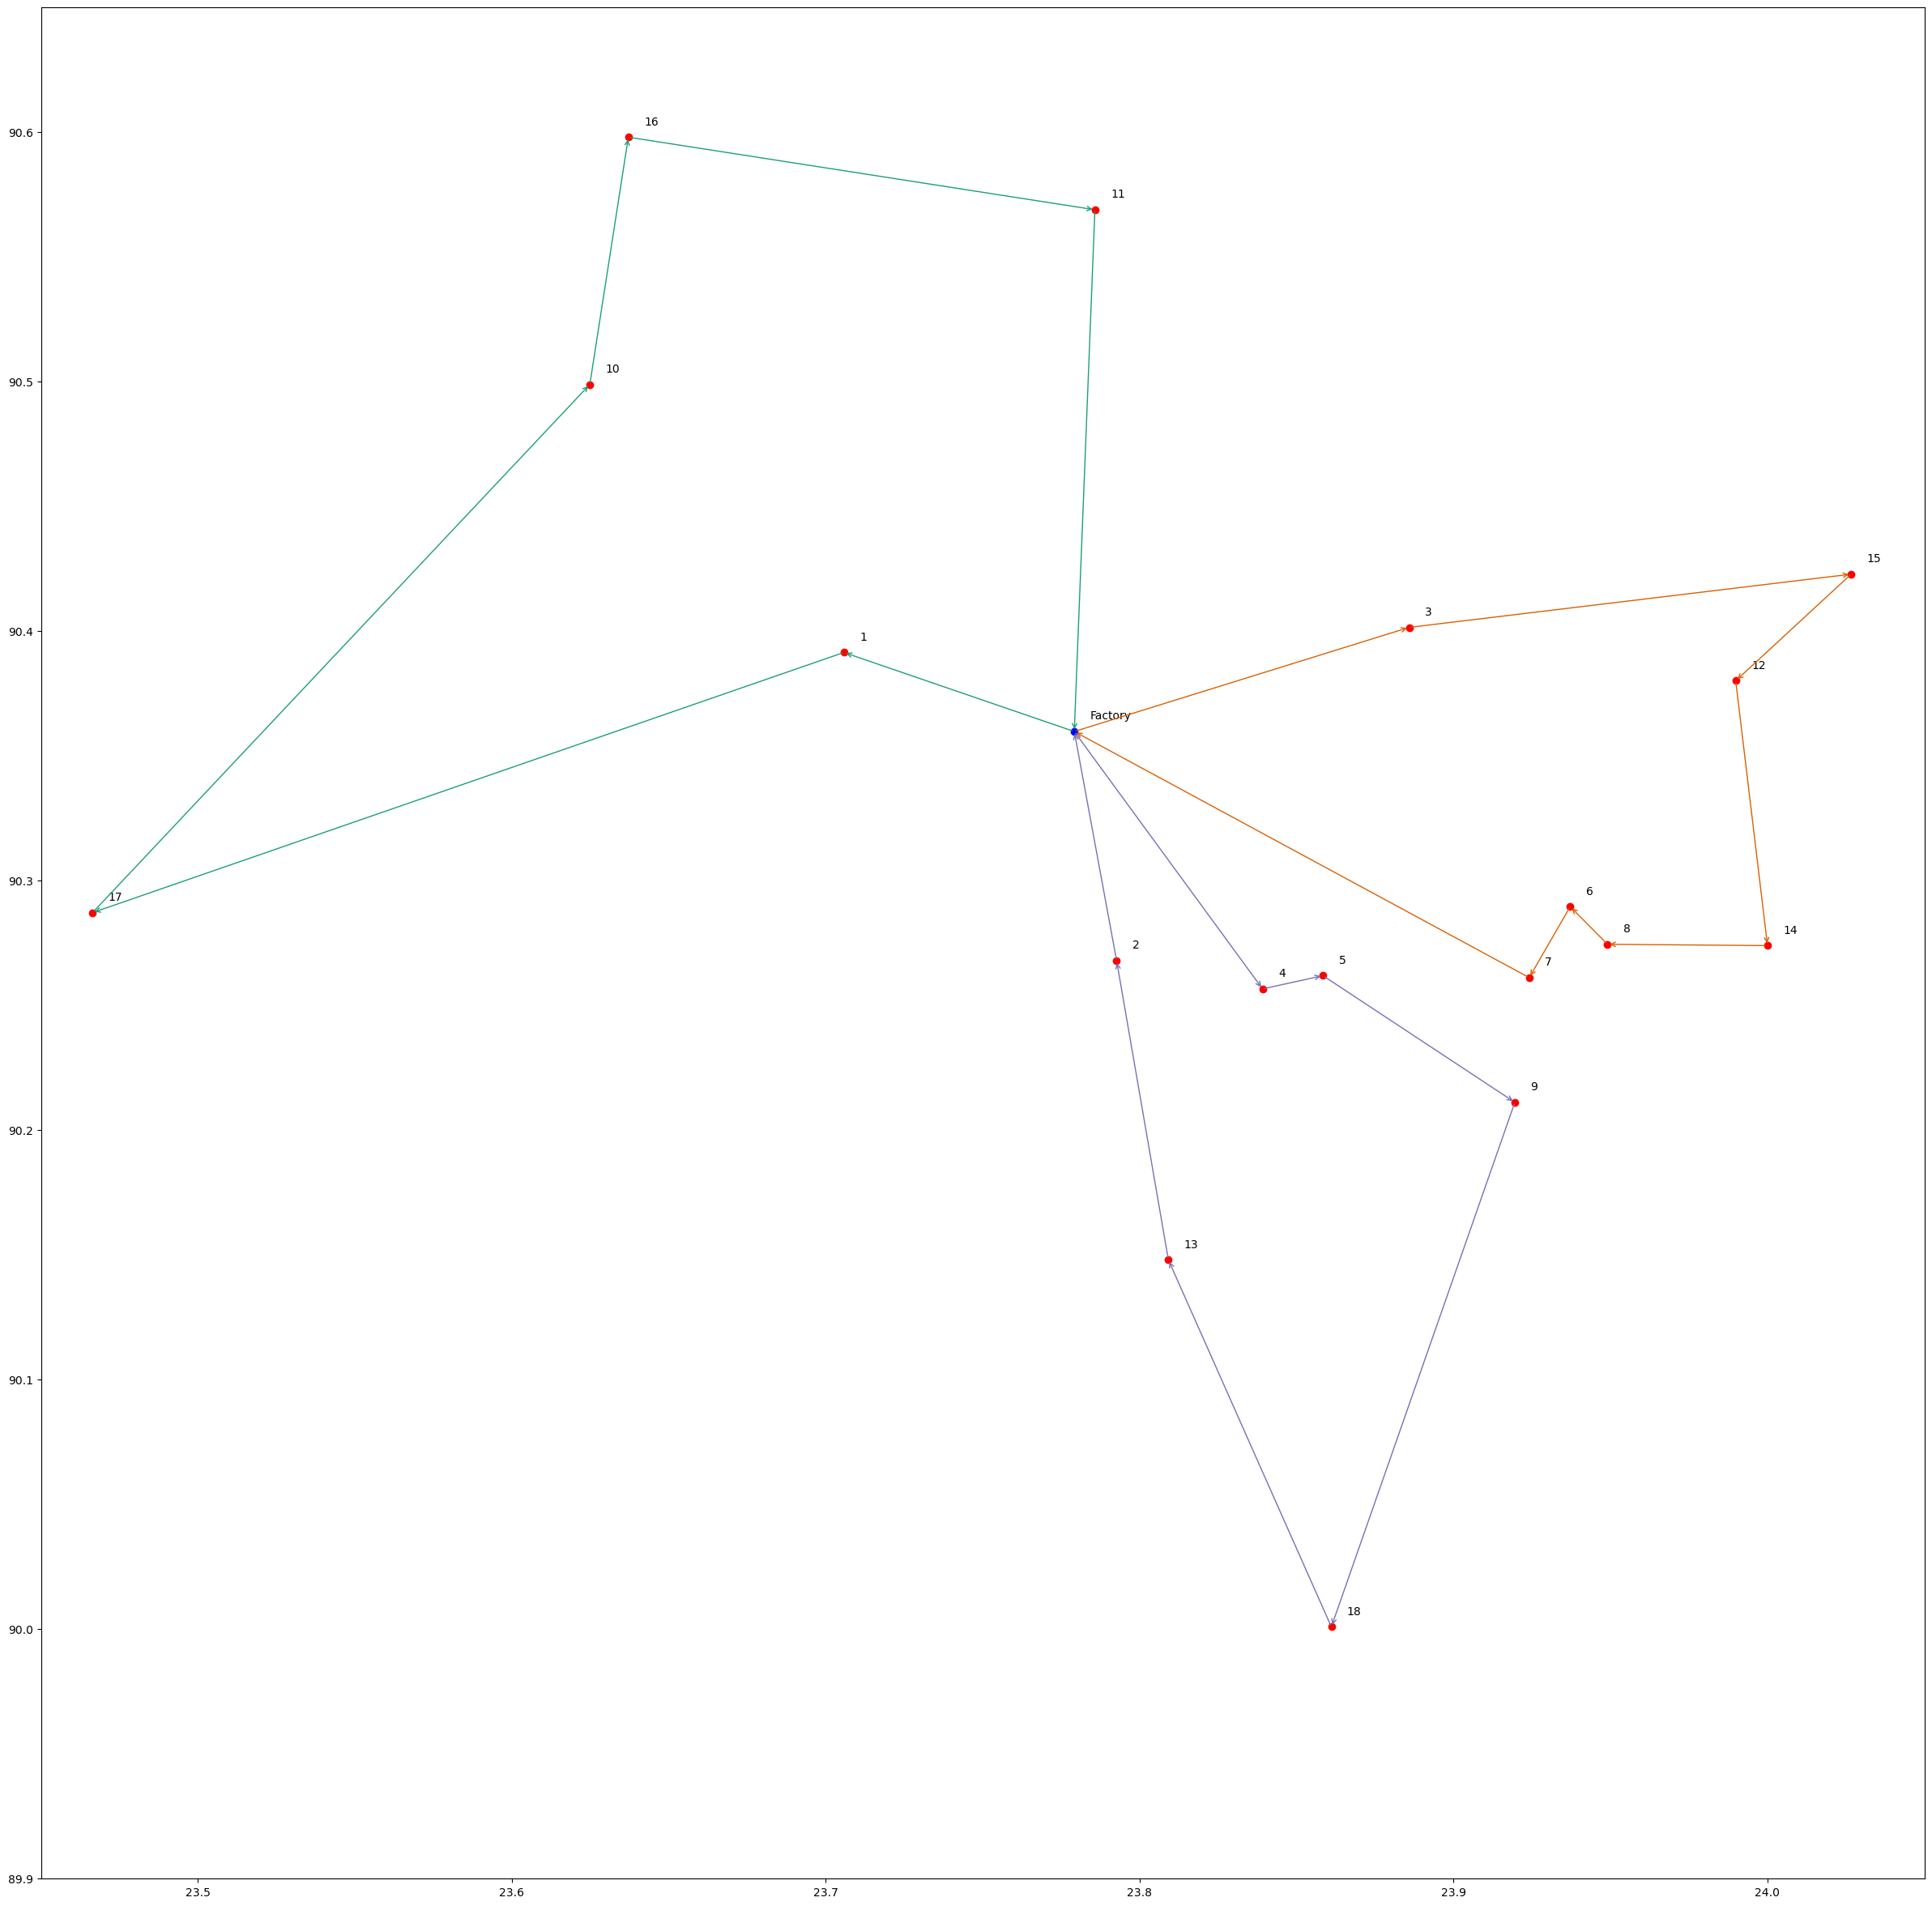

In [14]:
plt.figure(figsize=(30, 30))
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='b')
        plt.text(row['x'] + 0.005, row['y'] + 0.005, 'Factory')
    else:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 0.005, row['y'] + 0.005, f'{i}')
plt.xlim([23.45, 24.05])
plt.ylim([89.9, 90.65])
cmap = matplotlib.cm.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]
for v in range(int(pulp.value(n_vehicle))):
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()